# **AM 207**: Homework 6

_ _ _ _ _

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
Handed out: Thursday, March 12th, 2015<br>
Due: 11.59 P.M. Wednesday March 26th, 2015

**Instructions**:

+ Upload your answers in an ipython notebook to the dropbox on iSites, you can find the link on our homepage (http://am207.org/).

+ We will provide you imports for your ipython notebook. For the first part of this course, please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_LASTNAME_FIRSTNAME_HW6.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_LASTNAME_FIRSTNAME_HW0.tar.gz or AM207_LASTNAME_FIRSTNAME_HW0.zip

+ Please remember that your solution should be a **report**! We would like some explanations of your ideas, and ways to approach the solution. Also please comment your code. 

### Have Fun!
_ _ _ _ _
_ _ _ _ _

In [48]:
# Do NOT Add to this list without prior approval

import time
import math
import numpy as np
import scipy
import pandas as pd
from statsmodels.graphics.gofplots import qqplot_2samples


# for pure convenience
from scipy.stats import norm


%matplotlib inline
import matplotlib.pyplot as plt

# you don't have to use seaborn if you prefer plain matplotlib
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

### Question 1:  The Best Thing Since Sliced Sampling

Let's understand slice sampling by seeing some of the quirks.  
(a) Below you'll find a bad slice sampler named bad_slice_sampler.  Show that it works perfectly for unimodal distributions (guassians, cauchy, etc..).  How do you compare to the true distribution?  * **Hint:  You can get your distribution from scipy.stats and then use scipy.stats.probplot.  You can also plot the normed histogram.** * 

(b) Show that it doesn't work as well on multimodal distributions.  One suggestion is the gaussian mixture from lecture which we've defined below as ex2.  Draw 5000 samples and with ex2 I suggest a width of 0.2, but experiment with widths.  How does width affect sampling performance? 

(c) Fix bad_slice_sampler to get a correct univariate slice sampling implementation.  Call it good_slice_sampler and use the function skeleton we gave you below. What needs to be changed and why does that affect sampling performance?  Draw true samples for the mixture distribution (how might you sample from a mixture distribution) and compare to both you sampling implementations.  * **Hint: if you have statsmodels installed, you can use qqplot_2samples to create a qqplot based on samples.  What should that look like?  What does it look like for bad_slice sampler? ** *

(d) Implement a 2 dimensional slice sampler using the hyper-rectangle method.  Use the function skeleton given below. Implement (or use from a previous HW) a 2 dimensional metropolis-hastings sampler.  How do the two compare with respect to effective sample sizes, autocorrelation, and traceplots on the following form of a Banana PDF from HW4 (use a sample size of 10000 samples):

$ p(X) \propto {\rm exp} \left[ - \frac{1}{2a^2} \left(\sqrt{x_1^2 + x_2^2} -1 \right)^2 -  \frac{1}{2b^2} \left(x_2  - 1 \right)^2  \right] $ where $a=0.1$ and $b=1$.

In [2]:
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.30; l2=.70;
ex = lambda x: 0.5*norm.pdf(x,loc=-1,scale=0.3)+ 0.5*norm.pdf(x,loc=1,scale=0.3)
ex2 = lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)

def bad_slice_sampler(pdf, x0, width, division=0.5, sample_size=5000, burnin=0, thin=0):

    # initialize the sampler
    y0 = np.random.uniform(low=0,high=pdf(x0))
    samples = []

    # create an interval around the original point
    #init_unif = np.random.uniform(low=0,high=width)
    left = x0 - division*width
    right = left + width

    # slice sampling magic
    for i in range(sample_size + burnin):

        # select our interval
        while(y0 < pdf(left)): # left endpoint
            left = left - width

        while (y0 < pdf(right)): # right endpoint
            right = right + width

        while (True):
            # new proposal
            xstar  = np.random.uniform(low=left, high=right)

            # loop until we find the point inside the region
            if y0 < pdf(xstar):
                break
            else:
                # shrink interval
                if xstar < x0:
                    left = xstar
                if xstar > x0:
                    right = xstar

        # save the current sample
        samples.append(xstar)

        # the last sample is now the proposal
        x0 = xstar

        # get the new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0))

        # reset the interval around x0
        #init_unif = np.random.uniform(low=0,high=width)
        left = x0 - division*width
        right = left + width


    return np.array(samples[burnin:])


In [3]:
def good_slice_sampler(pdf, x0, width, sample_size=5000, burnin=0, thin=0):

    # initialize the sampler
    y0 = np.random.uniform(low=0,high=pdf(x0))
    samples = []

    # create an interval around the original point
    init_unif = np.random.uniform(low=0,high=width)
    left = x0 - init_unif
    right = left + width

    # slice sampling magic
    for i in range(sample_size + burnin):

        # select our interval
        while(y0 < pdf(left)): # left endpoint
            left = left - width

        while (y0 < pdf(right)): # right endpoint
            right = right + width

        while (True):
            # new proposal
            xstar  = np.random.uniform(low=left, high=right)

            # loop until we find the point inside the region
            if y0 < pdf(xstar):
                break
            else:
                # shrink interval
                if xstar < x0:
                    left = xstar
                if xstar > x0:
                    right = xstar

        # save the current sample
        samples.append(xstar)

        # the last sample is now the proposal
        x0 = xstar

        # get the new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0))

        # reset the interval around x0
        init_unif = np.random.uniform(low=0,high=width)
        left = x0 - init_unif
        right = left + width


    return np.array(samples[burnin:])

(a) Below you'll find a bad slice sampler named bad_slice_sampler.  Show that it works perfectly for unimodal distributions (guassians, cauchy, etc..).  How do you compare to the true distribution?  * **Hint:  You can get your distribution from scipy.stats and then use scipy.stats.probplot.  You can also plot the normed histogram.** * 

Answer:  Below we've used the slice sampler at two widths -- 0.2 and 6.0 to explore three distributions:  {Cauchy, Gaussian, Chi2}.  We see from both the normed histograms and the probplot that at both widths the bad_slice_sampler tracks the respective distributions closely.  This is harder to see in the probplot for the Cauchy (whose heavy tail made a normed histogram not too useful), but the probplots for the Bad Slice Samplers on the Cauchy are very similar to that of the Correct Sampler.

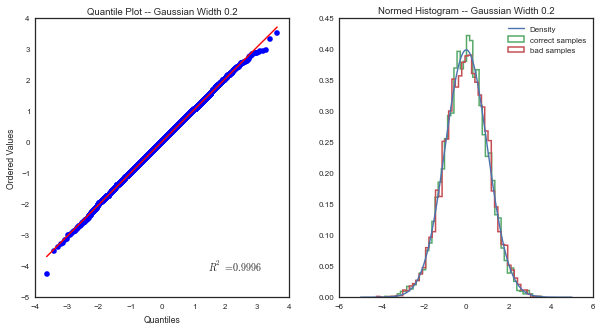

In [63]:
## First let's define our unimodal distributions
sample_size = 5000

unimodal1 = scipy.stats.norm(0.,1)
unimodal3 = scipy.stats.chi2(0,1)

## Now let's draw our gaussian samples
unimodal1_correct = unimodal1.rvs(sample_size)
unimodal1_bad = bad_slice_sampler(unimodal1.pdf, 1., .2, sample_size=5000)

f, axarr = plt.subplots(1,2,figsize=(10,5))

axarr[1].set_title("Normed Histogram -- Gaussian Width 0.2")

x = np.linspace(-5,5,10000)
axarr[1].plot(x, unimodal1.pdf(x), label="Density")
axarr[1].hist(unimodal1_correct,50,normed=True,histtype='step',linewidth=1.5,label='correct samples');
axarr[1].hist(unimodal1_bad,50,normed=True,histtype='step',linewidth=1.5,label='bad samples');
axarr[1].legend()

scipy.stats.probplot(unimodal1_bad,dist=scipy.stats.norm,sparams=(0.,1.), plot=axarr[0]);
axarr[0].set_title("Quantile Plot -- Gaussian Width 0.2")


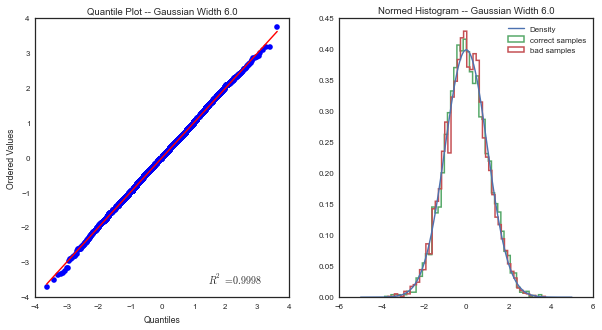

In [64]:
## Now let's draw our gaussian samples
unimodal1_correct = unimodal1.rvs(sample_size)
unimodal1_bad_width = bad_slice_sampler(unimodal1.pdf, 1., 6, sample_size=5000)

f, axarr = plt.subplots(1,2,figsize=(10,5))

axarr[1].set_title("Normed Histogram -- Gaussian Width 6.0")

x = np.linspace(-5,5,10000)
axarr[1].plot(x, unimodal1.pdf(x), label="Density")
axarr[1].hist(unimodal1_correct,50,normed=True,histtype='step',linewidth=1.5,label='correct samples');
axarr[1].hist(unimodal1_bad_width,50,normed=True,histtype='step',linewidth=1.5,label='bad samples');
axarr[1].legend()

scipy.stats.probplot(unimodal1_bad_width,dist=scipy.stats.norm,sparams=(0.,1.), plot=axarr[0]);
axarr[0].set_title("Quantile Plot -- Gaussian Width 6.0")


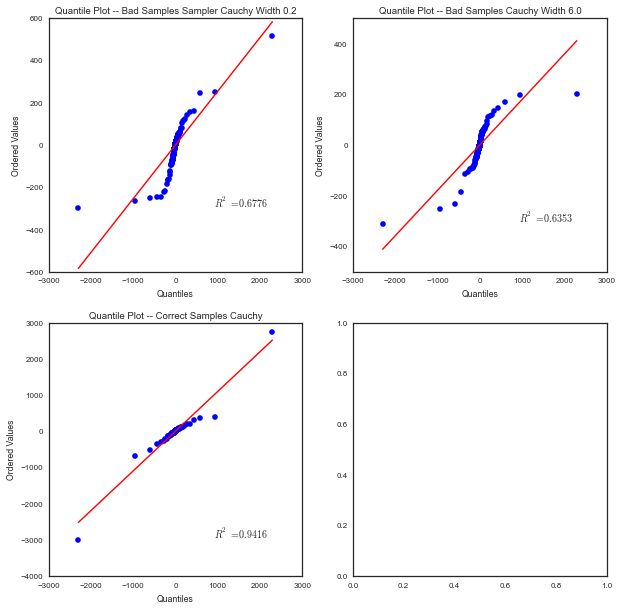

In [67]:
## Let's try Cauchy
unimodal2 = scipy.stats.cauchy(0,1)

## Now let's draw our gaussian samples
unimodal2_correct = unimodal2.rvs(sample_size)
unimodal2_bad = bad_slice_sampler(unimodal2.pdf, 1., .2, sample_size=5000)
unimodal2_bad_width = bad_slice_sampler(unimodal2.pdf, 1., 6, sample_size=5000)

f, axarr = plt.subplots(2,2,figsize=(10,10))

scipy.stats.probplot(unimodal2_bad,dist=scipy.stats.cauchy,sparams=(0.,1.), plot=axarr[0][0]);
scipy.stats.probplot(unimodal2_bad_width,dist=scipy.stats.cauchy,sparams=(0.,1.), plot=axarr[0][1]);
scipy.stats.probplot(unimodal2_correct,dist=scipy.stats.cauchy,sparams=(0.,1.), plot=axarr[1][0]);
axarr[0][0].set_title("Quantile Plot -- Bad Samples Sampler Cauchy Width 0.2")
axarr[0][1].set_title("Quantile Plot -- Bad Samples Cauchy Width 6.0")
axarr[1][0].set_title("Quantile Plot -- Correct Samples Cauchy")


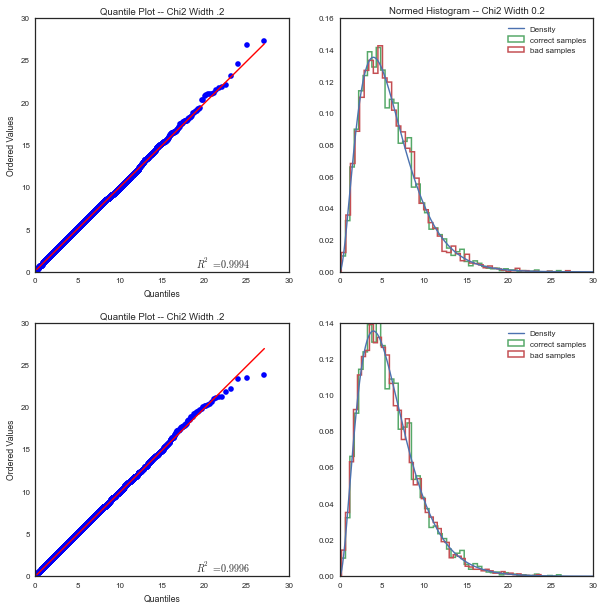

In [60]:
unimodal3 = scipy.stats.chi2(6)

## Now let's draw our chi2 samples
unimodal3_correct = unimodal3.rvs(sample_size)
unimodal3_bad = bad_slice_sampler(unimodal3.pdf, 1., .2, sample_size=5000)
unimodal3_bad_width = bad_slice_sampler(unimodal3.pdf, 1., .6, sample_size=5000)

f, axarr = plt.subplots(2,2,figsize=(10,10))

axarr[0][1].set_title("Normed Histogram -- Chi2 Width 0.2")

x = np.linspace(0,30,10000)
axarr[0][1].plot(x, unimodal3.pdf(x), label="Density")
axarr[0][1].hist(unimodal3_correct,50,normed=True,histtype='step',linewidth=1.5,label='correct samples');
axarr[0][1].hist(unimodal3_bad,50,normed=True,histtype='step',linewidth=1.5,label='bad samples');
axarr[0][1].legend()

scipy.stats.probplot(unimodal3_bad,dist=scipy.stats.chi2,sparams=(6), plot=axarr[0][0]);
axarr[0][0].set_title("Quantile Plot -- Chi2 Width .2")

axarr[1][1].plot(x, unimodal3.pdf(x), label="Density")
axarr[1][1].hist(unimodal3_correct,50,normed=True,histtype='step',linewidth=1.5,label='correct samples');
axarr[1][1].hist(unimodal3_bad_width,50,normed=True,histtype='step',linewidth=1.5,label='bad samples');
axarr[1][1].legend()

scipy.stats.probplot(unimodal3_bad_width,dist=scipy.stats.chi2,sparams=(6), plot=axarr[1][0]);
axarr[1][0].set_title("Quantile Plot -- Chi2 Width .2")

(b) Show that it doesn't work as well on multimodal distributions.  One suggestion is the gaussian mixture from lecture which we've defined below as ex2.  Draw 5000 samples and with ex2 I suggest a width of 0.2, but experiment with widths.  How does width affect sampling performance? 

Answer:  We'll use 6 widths: {0.2,1,3,5,6,8}.  From the generated qqplots and observing the histograms below, it's clear that at widths 0.2 (and even more clearly), 5.0 and 6.0 that the bad_slice_sampling does a poor job of sampling the mixture distribution.  There's a permanent divergence in the qqplot and in the normed histogram we see clear undersampling of the right mode and over sampling of the left mode.

In [77]:
# Correctly sample from mixture distribution
def sample_ex2(sample_size, mu1, sigma1, mu2, sigma2, l1):
    mode1=np.random.normal(mu1,sigma1,sample_size)
    mode2=np.random.normal(mu2,sigma2,sample_size)
    flip_modes =np.random.uniform(size=sample_size)<l1 # chooses between r1 and r2
    mode2[flip_modes]=mode1[flip_modes]
    return mode2


## Let's generate our correct samples
correct_samples = sample_ex2(5000, mu1, sigma1, mu2, sigma2, l1)

## And now our bad ones at various widths
bad_samples_width1 = bad_slice_sampler(ex2, 1., .2, sample_size=5000)
bad_samples_width2 = bad_slice_sampler(ex2, 1., 1., sample_size=5000)
bad_samples_width3 = bad_slice_sampler(ex2, 1., 3., sample_size=5000)
bad_samples_width4 = bad_slice_sampler(ex2, 1., 5., sample_size=5000)
bad_samples_width5 = bad_slice_sampler(ex2, 1., 6., sample_size=5000)
bad_samples_width6 = bad_slice_sampler(ex2, 1., 8., sample_size=5000)


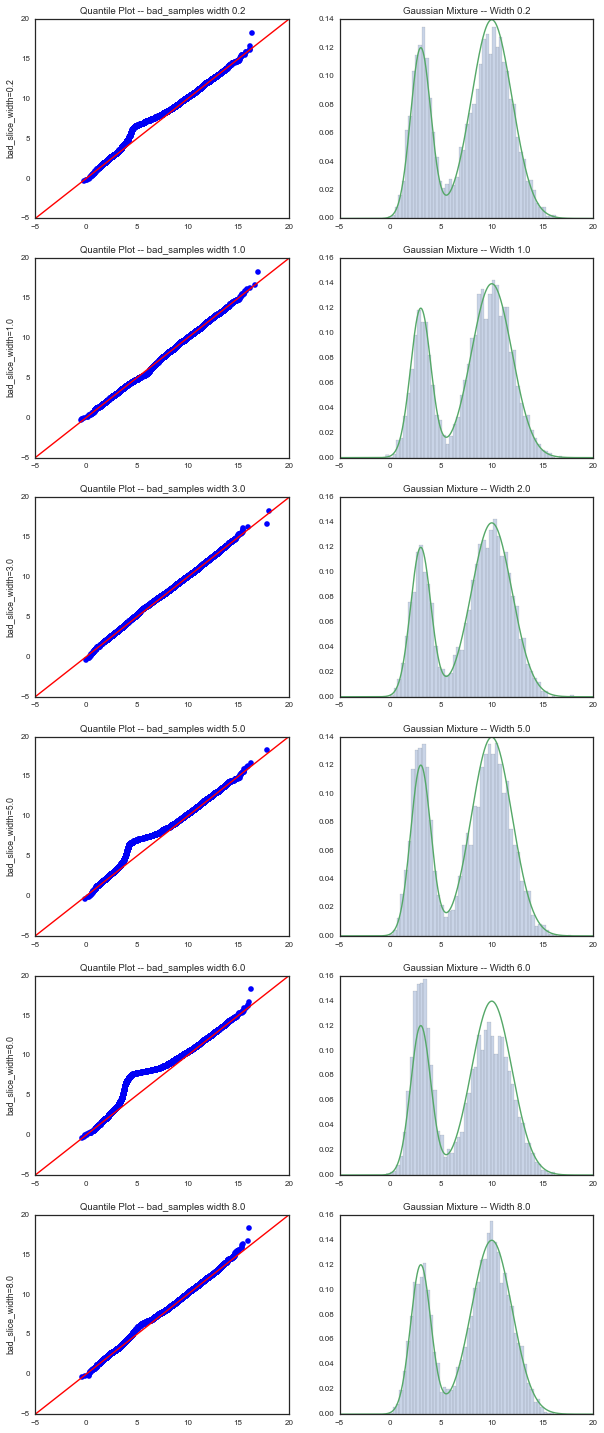

In [90]:
## Let's plot the qqplots of the bad samples and normed histograms for each width
f, axarr = plt.subplots(6,2,figsize=(10,25))

qqplot_2samples(correct_samples,bad_samples_width1, xlabel = "", ylabel = "bad_slice_width=0.2", line='45', ax=axarr[0][0]);
qqplot_2samples(correct_samples,bad_samples_width2, xlabel = "", ylabel = "bad_slice_width=1.0", line='45', ax=axarr[1][0]);
qqplot_2samples(correct_samples,bad_samples_width3, xlabel = "", ylabel = "bad_slice_width=3.0", line='45', ax=axarr[2][0]);
qqplot_2samples(correct_samples,bad_samples_width4, xlabel = "", ylabel = "bad_slice_width=5.0", line='45', ax=axarr[3][0]);
qqplot_2samples(correct_samples,bad_samples_width5, xlabel = "", ylabel = "bad_slice_width=6.0", line='45', ax=axarr[4][0]);
qqplot_2samples(correct_samples,bad_samples_width6, xlabel = "", ylabel = "bad_slice_width=8.0", line='45', ax=axarr[5][0]);

axarr[0][0].set_title("Quantile Plot -- bad_samples width 0.2")
axarr[1][0].set_title("Quantile Plot -- bad_samples width 1.0")
axarr[2][0].set_title("Quantile Plot -- bad_samples width 3.0")
axarr[3][0].set_title("Quantile Plot -- bad_samples width 5.0")
axarr[4][0].set_title("Quantile Plot -- bad_samples width 6.0")
axarr[5][0].set_title("Quantile Plot -- bad_samples width 8.0")

## Normed histograms
x1 = np.linspace(-5,20,5000)
axarr[0][1].hist(bad_samples_width1, 50, normed=1, alpha=0.3, zorder=1, label = "Width 0.2")
axarr[0][1].plot(x1,ex2(x1), zorder=2)
axarr[0][1].set_title("Gaussian Mixture -- Width 0.2")

axarr[1][1].hist(bad_samples_width2, 50, normed=1, alpha=0.3, zorder=1, label = "Width 1.0")
axarr[1][1].plot(x1,ex2(x1), zorder=2)
axarr[1][1].set_title("Gaussian Mixture -- Width 1.0")

axarr[2][1].hist(bad_samples_width3, 50, normed=1, alpha=0.3, zorder=1, label = "Width 2.0")
axarr[2][1].plot(x1,ex2(x1), zorder=2)
axarr[2][1].set_title("Gaussian Mixture -- Width 2.0")

axarr[3][1].hist(bad_samples_width4, 50, normed=1, alpha=0.3, zorder=1, label = "Width 5.0")
axarr[3][1].plot(x1,ex2(x1), zorder=2)
axarr[3][1].set_title("Gaussian Mixture -- Width 5.0")

axarr[4][1].hist(bad_samples_width5, 50, normed=1, alpha=0.3, zorder=1, label = "Width 6.0")
axarr[4][1].plot(x1,ex2(x1), zorder=2)
axarr[4][1].set_title("Gaussian Mixture -- Width 6.0")

axarr[5][1].hist(bad_samples_width6, 50, normed=1, alpha=0.3, zorder=1, label = "Width 8.0")
axarr[5][1].plot(x1,ex2(x1), zorder=2)
axarr[5][1].set_title("Gaussian Mixture -- Width 8.0")

(c) Fix bad_slice_sampler to get a correct univariate slice sampling implementation.  Call it good_slice_sampler and use the function skeleton we gave you below. What needs to be changed and why does that affect sampling performance?  Draw true samples for the mixture distribution (how might you sample from a mixture distribution) and compare to both you sampling implementations.  * **Hint: if you have statsmodels installed, you can use qqplot_2samples to create a qqplot based on samples.  What should that look like?  What does it look like for bad_slice sampler? ** *

Answer:  The good_slice_sampler is defined and implemented above.  It corrects bad_slice_sampler by using a random interval of width w around our sample points before stepping out.  Bad_slice_sampler merely centered an interval around the sample points before steppin out. By randomy constructing an interval, we meet detailed balance and you can see in the qqplots and normed histograms for the good_slice_sampler that it does a much better sampling job at the various widths (including 5.0 and 6.0 where bad_slice_sampler failed).  The drawing of the correct mixture samples and the comparison to samples from the bad_slice_sampler took place in part b.

In [91]:
## And now our good ones at various widths
good_samples_width1 = good_slice_sampler(ex2, 1., .2, sample_size=5000)
good_samples_width2 = good_slice_sampler(ex2, 1., 1., sample_size=5000)
good_samples_width3 = good_slice_sampler(ex2, 1., 3., sample_size=5000)
good_samples_width4 = good_slice_sampler(ex2, 1., 5., sample_size=5000)
good_samples_width5 = good_slice_sampler(ex2, 1., 6., sample_size=5000)
good_samples_width6 = good_slice_sampler(ex2, 1., 8., sample_size=5000)

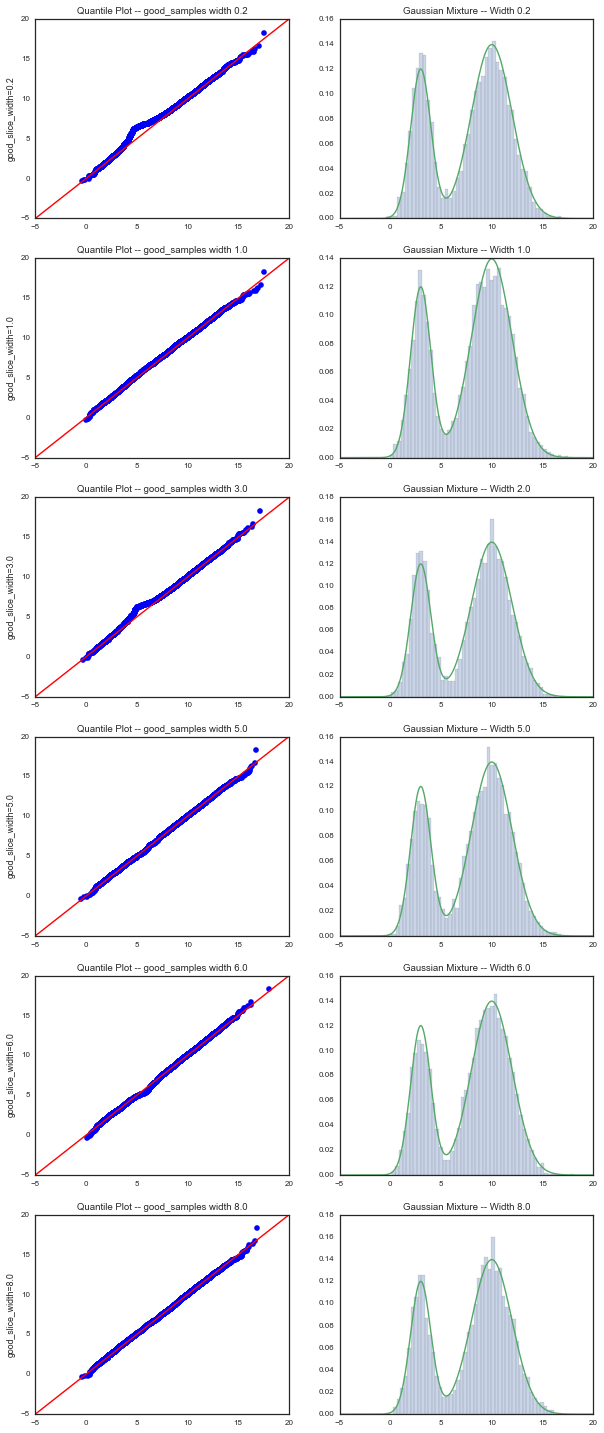

In [93]:
## Let's plot the qqplots of the good samples and normed histograms for each width
f, axarr = plt.subplots(6,2,figsize=(10,25))

qqplot_2samples(correct_samples,good_samples_width1, xlabel = "", ylabel = "good_slice_width=0.2", line='45', ax=axarr[0][0]);
qqplot_2samples(correct_samples,good_samples_width2, xlabel = "", ylabel = "good_slice_width=1.0", line='45', ax=axarr[1][0]);
qqplot_2samples(correct_samples,good_samples_width3, xlabel = "", ylabel = "good_slice_width=3.0", line='45', ax=axarr[2][0]);
qqplot_2samples(correct_samples,good_samples_width4, xlabel = "", ylabel = "good_slice_width=5.0", line='45', ax=axarr[3][0]);
qqplot_2samples(correct_samples,good_samples_width5, xlabel = "", ylabel = "good_slice_width=6.0", line='45', ax=axarr[4][0]);
qqplot_2samples(correct_samples,good_samples_width6, xlabel = "", ylabel = "good_slice_width=8.0", line='45', ax=axarr[5][0]);

axarr[0][0].set_title("Quantile Plot -- good_samples width 0.2")
axarr[1][0].set_title("Quantile Plot -- good_samples width 1.0")
axarr[2][0].set_title("Quantile Plot -- good_samples width 3.0")
axarr[3][0].set_title("Quantile Plot -- good_samples width 5.0")
axarr[4][0].set_title("Quantile Plot -- good_samples width 6.0")
axarr[5][0].set_title("Quantile Plot -- good_samples width 8.0")

## Normed histograms
x1 = np.linspace(-5,20,5000)
axarr[0][1].hist(good_samples_width1, 50, normed=1, alpha=0.3, zorder=1, label = "Width 0.2")
axarr[0][1].plot(x1,ex2(x1), zorder=2)
axarr[0][1].set_title("Gaussian Mixture -- Width 0.2")

axarr[1][1].hist(good_samples_width2, 50, normed=1, alpha=0.3, zorder=1, label = "Width 1.0")
axarr[1][1].plot(x1,ex2(x1), zorder=2)
axarr[1][1].set_title("Gaussian Mixture -- Width 1.0")

axarr[2][1].hist(good_samples_width3, 50, normed=1, alpha=0.3, zorder=1, label = "Width 2.0")
axarr[2][1].plot(x1,ex2(x1), zorder=2)
axarr[2][1].set_title("Gaussian Mixture -- Width 2.0")

axarr[3][1].hist(good_samples_width4, 50, normed=1, alpha=0.3, zorder=1, label = "Width 5.0")
axarr[3][1].plot(x1,ex2(x1), zorder=2)
axarr[3][1].set_title("Gaussian Mixture -- Width 5.0")

axarr[4][1].hist(good_samples_width5, 50, normed=1, alpha=0.3, zorder=1, label = "Width 6.0")
axarr[4][1].plot(x1,ex2(x1), zorder=2)
axarr[4][1].set_title("Gaussian Mixture -- Width 6.0")

axarr[5][1].hist(good_samples_width6, 50, normed=1, alpha=0.3, zorder=1, label = "Width 8.0")
axarr[5][1].plot(x1,ex2(x1), zorder=2)
axarr[5][1].set_title("Gaussian Mixture -- Width 8.0")

(d) Implement a 2 dimensional slice sampler using the hyper-rectangle method.  Use the function skeleton given below. Implement (or use from a previous HW) a 2 dimensional metropolis-hastings sampler.  How do the two compare with respect to effective sample sizes, autocorrelation, and traceplots on the following form of a Banana PDF from HW4 (use a sample size of 10000 samples):

$ p(X) \propto {\rm exp} \left[ - \frac{1}{2a^2} \left(\sqrt{x_1^2 + x_2^2} -1 \right)^2 -  \frac{1}{2b^2} \left(x_2  - 1 \right)^2  \right] $ where $a=0.1$ and $b=1$.

Answer:  As shown below, using a width of 10 for the 2d slice sampler and a step size of 1 for 2d Metropolis Hastings, the basic conclusions are the at MH performs an order of magnitude faster, but is more correlated (as seen by the traceplots and the effective sample size).  When taking larger samples sizes in which case burnin/thinning become less of a factor, some of the benefits of this 2d slice sampling implementation (i.e. more uncorrelated samples compared to MH) seem to disappear while MH keeps the performance advantage.  Keep in mind that this implementation of 2d slice sampling isn't quite perfect since it only tests that the points on the simplex (or the "corners") are above or below the function.  It doesn't test the entire surface boundary of the rectangles as it should.

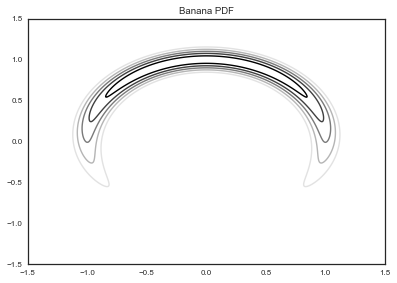

In [4]:
## First Let's just plot our pdf

banana_pdf = lambda x: np.exp(-50*((x[0]**2+x[1]**2)**0.5-1)**2-0.5*(x[1]-1)**2)

log_banana = lambda x: -50*((x[0]**2+x[1]**2)**0.5 -1)**2 - 0.5*(x[1]-1)**2

x = np.linspace(-1.5, 1.5, 1000)
y = np.linspace(-1.5, 1.5, 1000)

xx, yy = np.meshgrid(x,y)
zz = np.zeros((1000,1000))

for i in range(len(x)):
    for j in range(len(y)):
        zz[i, j] = banana_pdf([xx[i,j], yy[i,j]])
        
plt.contour(xx,yy,zz)

plt.title("Banana PDF")

In [28]:
## Let's define Metropolis Hastings

def MH(logpdf, X0, sigma, sample_size=10000,burnin=0,thin=0):
    acc = 0.0
    result = np.zeros((sample_size,2))
    r = np.random.random(sample_size)
    for i in xrange(sample_size+burnin):
        
        x1 = np.random.normal(X0[0], sigma)
        x2 = np.random.normal(X0[1], sigma)
        p = logpdf([x1,x2])-logpdf(X0)
        if np.log(r[i]) < p:
            acc += 1
            X0[0] = x1
            X0[1] = x2
        result[i] = X0
    print "Acceptance ratio is "+str(acc/sample_size)+"."
    return result[burnin:]

def slice_sampler_2d(pdf, x0, width, sample_size=5000, burnin=0, thin=0):
    
    ## Implement 2d slice sampler here
    ## see lecture 11 notes for a head start
    
    # initialize the sampler
    y0 = np.random.uniform(low=0,high=pdf(x0))
    samples = []

    # a hyperrectangle around the original point
    rectUnifs = np.random.uniform(size=2)
    rectLefts = x0 - width*rectUnifs
    rectRights = rectLefts + width

    # do the sampling
    for i in range(burnin + sample_size):
        while (True):
            # x* proposal
            xstarUnifs = np.random.uniform(size=2)
            xstar = rectLefts + xstarUnifs*(rectRights - rectLefts)

            # loop until we find the point inside the region
            if y0 < pdf(xstar):
                break
            else:
                # shrink rectangle to  make the search faster
                for j in range(2):
                    if xstar[j] < x0[j]:
                        rectLefts[j] = xstar[j]
                    else:
                        rectRights[j] = xstar[j]
                
        # save the current sample
        samples.append(xstar)

        # the last sample is now the proposal
        x0 = xstar

        # get the new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0))

        # reset the rectangle
        rectUnifs = np.random.uniform(size=2)
        rectLefts = x0 - width*rectUnifs
        rectRights = rectLefts + width


    # extract samples
    return np.array(samples[burnin:])

# autocorrelation with lag t
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# effective sample size
def neff(x, T):
    n = len(x)
    rho = 1.0
    for i in xrange(T):
        rho += 2*rhot(x, i+1)
    return n/rho


In [45]:
# Define MH Varables
X0=[0,1]
sigma=1

start_time = time.clock()
mh_samples = MH(log_banana, X0, sigma, sample_size=10000)
print "MH Execution Time:  {}".format(time.clock() - start_time)



Acceptance rate is 0.1364.
MH Execution Time:  0.04194


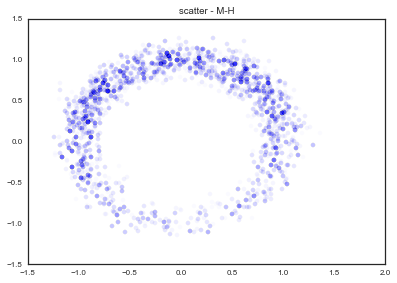

Essential sample size for MH: 624.011915209


In [43]:
plt.title("scatter - M-H")
plt.scatter(mh_samples[:,0],mh_samples[:,1],alpha=0.02)
plt.show()

print "Essential sample size for MH: {}".format(neff(mh_samples[:,1], 100))

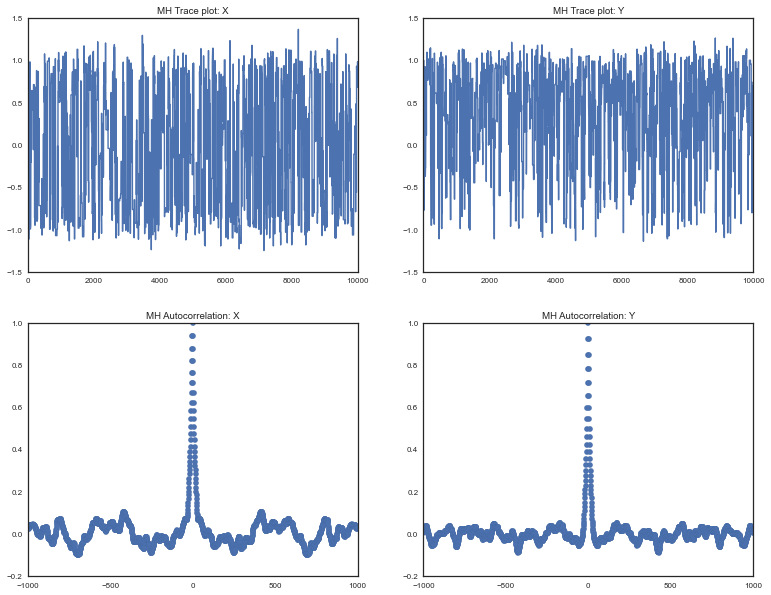

In [39]:
f, axarr = plt.subplots(2,2, figsize=(13,10))
axarr[0][0].plot(mh_samples[:,0])
axarr[0][0].set_title("MH Trace plot: X " )

axarr[0][1].plot(mh_samples[:,1])
axarr[0][1].set_title("MH Trace plot: Y " )


axarr[1][0].acorr(mh_samples[:,0] - np.mean(mh_samples[:,0]), normed=True, usevlines=False, maxlags=1000)
axarr[1][0].set_title("MH Autocorrelation: X")

axarr[1][1].acorr(mh_samples[:,1] - np.mean(mh_samples[:,1]), normed=True, usevlines=False, maxlags=1000)
axarr[1][1].set_title("MH Autocorrelation: Y")

In [46]:
X0=[0,1]
sigma=.5

start_time = time.clock()
ss_2d_samples = slice_sampler_2d(banana_pdf, X0, 10., sample_size=10000)
print "2d Slice Execution Time:  {}".format(time.clock() - start_time)


2d Slice Execution Time:  0.692845


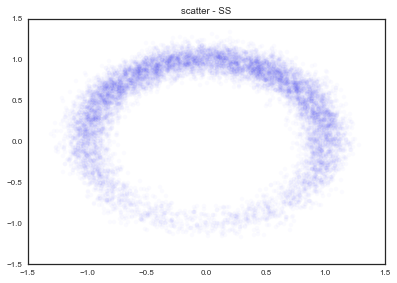

Essential sample size for 2d Slice Sampling: 2088.00667468


In [44]:
plt.title("scatter - SS")
plt.scatter(ss_2d_samples[:,0],ss_2d_samples[:,1],alpha=0.02)
plt.show()

print "Essential sample size for 2d Slice Sampling: {}".format(neff(ss_2d_samples[:,1], 100))

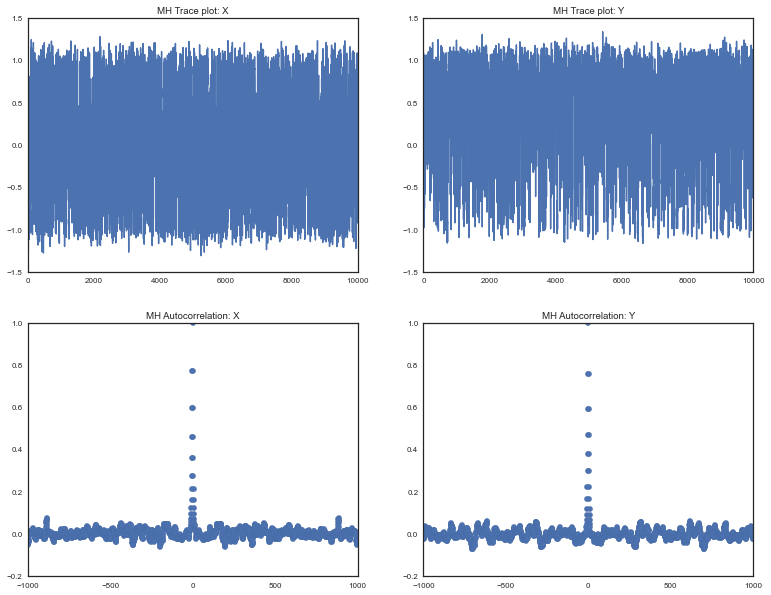

In [42]:
f, axarr = plt.subplots(2,2, figsize=(13,10))
axarr[0][0].plot(ss_2d_samples[:,0])
axarr[0][0].set_title("MH Trace plot: X " )

axarr[0][1].plot(ss_2d_samples[:,1])
axarr[0][1].set_title("MH Trace plot: Y " )

axarr[1][0].acorr(ss_2d_samples[:,0] - np.mean(ss_2d_samples[:,0]), normed=True, usevlines=False, maxlags=1000)
axarr[1][0].set_title("MH Autocorrelation: X")

axarr[1][1].acorr(ss_2d_samples[:,1] - np.mean(ss_2d_samples[:,1]), normed=True, usevlines=False, maxlags=1000)
axarr[1][1].set_title("MH Autocorrelation: Y")

### Question 2:  Hierarchical Modeling is No Victorian Secret

We have (from Bayesian Data Analysis, Gelman et. al.) a dataset of kidney cancer death rates by county in the US.  Let's assume that we can use a Poisson distribution to model the per county kidney death rate

$$ y_j \sim Poisson(n_j\theta_j) \\
 \theta_j \sim Gamma(\alpha, \beta)$$.

where $n_j$ is the total population of county j, $y_j$ is the number of kidney cancer deaths in county j and $\theta_j$ is the underlying death rate for county j.  A Poisson model makes sense because kidney cancer incidence should be a rare event (we hope!) and the Poisson is a good distribution for modeling rare events.  The gamma is a distribution with the right support that is conveniently the conjugate distribution for the Poisson. Before we were exposed to hierarchical modeling, we'd be inclined to use "full pooling" and choose one prior distribution for $\theta$ for all the counties.  Now that we have access to hierarchical modeling let's be a bit more sophisticated.  Let's define a hierarchical model where the $\alpha$ and $\beta$ are also drawn from gamma distributions as well.  Our full hierarchical model is defined below:
$$ y_j \sim Poisson(n_j\theta_j) \\
 \theta_j \sim Gamma(\alpha, \beta)\\
 \alpha \sim Gamma(a_{\alpha},b_{\alpha})\\
 \beta \sim Gamma(a_{\beta},b_{\beta})$$.


(a) Show that a Gamma is conjugate prior to a Poisson and write out the joint posterior density.

(b) Similar to what we did in lecture with the rat tumor and the beta binomial model, we can find full conditional distributions for $\lambda_j$, $\alpha$ and $\beta$.  Derive them.

(c) How might you choose your prior hyperparameters $\{a_{\alpha},\ b_{\alpha},\ a_{\beta},\ b_{\beta}\ \}$?

(d) You should have two conditional distributions that you need to sample from with MCMC (with some clever manipulations you may have just one) and one conditional distribution that you can sample from a Gamma.  Run a Gibbs sampler with the county data in <a href="HW6.csv">this file</a>.  (Feel free to use a subset of counties, e.g. the counties an individual state like Texas.  Only run the whole data set if you're in an ambitious "I'm at the top of the hierarchy" mood).  You'll want the columns death_count, population, and maybe (if you don't want to calculate it yourself) mortality_rate.  Use your good_slice_sampler (or as an alternative recycle a MH sampler from a previous HW) for drawing samples from the distributions that aren't from a known model.  Give posterior plots, posterior metrics and traceplots/other convergence criteria.  * ** Beware:  The gamma distribution in scipy.stat uses a different convention than we're used to.  It uses b as a scale parameter and you enter that parameter as the reciprocal of the normal scale parameter.  So, the pdf of $Gamma(a,b)$ in scipy would be scipy.stats.gamma.pdf(x, a, scale=1./b) ** *

One of the advantages of the Poisson Gamma hiearchical model in this case is that it acts almost like a regularizer for population disparities.  Counties with small populations will be highly influenced by the prior, whereas counties with high population (high data counts) will be influenced by the data. What kinds of suggestion do you have for improving the prior?

(a) Show that a Gamma is conjugate prior to a Poisson and write out the joint posterior density.

Given a Poisson likelihood -- $y_j \sim Poisson(n_j\theta_j)$ -- and a Gamma prior -- $\theta_j \sim Gamma(\alpha,\beta)$ our full posterior density (ignoring for now the normalization constant) wold be determined as follows:

$P(y_j|\theta_j) =  \dfrac{ (n_j\theta_j)^{y_j}e^{-n_j\theta_j}}{y_j!}$ and $P(\theta_j|\alpha,\beta) = \dfrac{ \beta^{\alpha}\theta_j^{\alpha-1}e^{-\beta\theta_j} } { \Gamma(\alpha)}$

Multiplying these two distributions, we get:

$P(\theta_j|\alpha, \beta,y_j) = \dfrac{ (n_j\theta)_j^{y_j}e^{-n_j\theta_j}}{y_j!} \dfrac{ \beta^{\alpha}\theta_j^{\alpha-1}e^{-\beta\theta_j} } { \Gamma(\alpha)} =  (\dfrac{n_j^{y_j}\beta^{\alpha}}{y_j!\Gamma(\alpha) }) \theta_j^ {\alpha + y_j - 1} e^{-(\beta + n_j)\theta_j}   $

Knowing that $P(\theta_j|\alpha, \beta,y_j)$ is a probability distribution and incorporating $(\dfrac{n_j^{y_j}\beta^{\alpha}}{y_j!\Gamma(\alpha) })$ into the normalization constant, we see that $P(\theta_j|\alpha, \beta,y_j) = Gamma(\alpha + y_j, \beta + n_j)$ and that more generally, Gammas and Poissons are conjugate distributions.

(b) Similar to what we did in lecture with the rat tumor and the beta binomial model, we can find full conditional distributions for $\lambda_j$, $\alpha$ and $\beta$.  Derive them.

Let's collect our likelihood and prior's
$$ p(y_i | \theta_i) = \frac{(n_i\theta_i)^{y_i} e^{-n_i\theta_i}}{y_i!} $$

$$ p(\theta_i | \alpha, \beta) = \frac{\beta^\alpha \theta_i^{\alpha-1} e^{-\beta \theta_i}}{\Gamma(\alpha)} $$

$$ p( \alpha | a_{\alpha}, b_{\alpha} ) = \frac{b_{\alpha}^{a_\alpha} \alpha^{a_\alpha - 1} e^{-b_\alpha \alpha}}{\Gamma(a_\alpha)} $$

$$ p( \beta | a_\beta, b_\beta ) = \frac{b_\beta^{a_\beta} \beta^{a_\beta - 1} e^{-b_\beta \beta}}{\Gamma(a_\beta)} $$

Taking the product, we have our joint:

$$ \boxed {p( \theta | \alpha, \beta, y) \propto \prod_i \frac{(n_i\theta_i)^{y_i} e^{-n_i\theta_i}}{y_i!} \frac{\beta^\alpha \theta_i^{\alpha - 1} e^{-\beta \theta_i}}{\Gamma (\alpha)} p(\alpha) p(\beta) }$$

where 

$$ p(\alpha) = \frac{b_\alpha^{a_\alpha} \alpha^{a_{\alpha} - 1} e^{-b_\alpha \alpha}}{\Gamma(a_\alpha)} $$

$$ p(\beta) = \frac{b_\beta^{a_\beta} \beta^{a_{\beta} - 1} e^{-b_\beta\beta}}{\Gamma(a_\beta)} $$




**$\theta_i$ conditional**:   we just borrow our derivation in part a:

$$ p(\theta_i | \alpha, \beta, y_i) = \text{Gamma}((\alpha + y_i), (\beta + n_i)) $$

**$\alpha$ conditional**: Discarding all terms from the joint without $\alpha$-dependence:

$$ p(\alpha | \theta_i, \beta, y) \propto \prod_i \frac{\beta^\alpha \theta_i^{\alpha - 1}}{\Gamma(\alpha)} (p(\alpha)) \propto \prod_i \frac{\beta^\alpha \theta_i^{\alpha}}{\Gamma(\alpha)} p(\alpha) \propto \prod_i \frac{\beta^\alpha \theta_i^{\alpha}}{\Gamma(\alpha)} (\alpha^{a_\alpha - 1} e^{-b_\alpha \alpha} )$$

$$ \propto (\prod_i \lambda_i )^\alpha (\frac{\beta^\alpha}{\Gamma(\alpha)})^n \alpha^{a_\alpha - 1} e^{-b_\alpha \alpha} $$

**$\beta$ conditional**: Discarding all terms from the joint without $\beta$-dependence:

$$ p(\beta | \theta_i, \alpha, y) \propto \prod_i \beta^{\alpha} e^{-\beta \theta_i} p(\beta) \propto \beta^{n\alpha} e^{-\beta \sum_{i} \theta_i} (\beta^{a_{\beta} - 1} e^{-b_\beta\beta}) \propto \beta^{n\alpha + a_\beta - 1} e^{- \beta( \sum_{i} \theta_i + b_\beta)}  $$

$$ p(\beta | \theta_i, \alpha, y) \propto \text{Gamma} (n\alpha + a_\beta, \sum_i \theta_i + b_\beta ) $$

(c) How might you choose your prior hyperparameters $\{a_{\alpha},\ b_{\alpha},\ a_{\beta},\ b_{\beta}\ \}$?

We've determined that the $\alpha$s should have a mean of around 20. Because we have a very weak sense for the value of alpha and beta, we should construct $\alpha$ and $
\beta$ such that they're non-informative i.e. they should have very large variances.  We will pick $a_\alpha$ and $b_\alpha$ so that this is accomplished: choose $a_\alpha$ = 0.002 and $b_\alpha$ = 0.0001. Thus, our mean is 20 and our variance is quite large.

Our values for beta are more difficult to pick. A cursory understanding of the data set tells us that $\beta$ should have a mean of around 100,000.  Since we really don't know what value  $\beta$ should have, we'd expect that the variance of beta should also be very large.  Unfortunately, beta's scale is so high that these values of beta seem to defeat the hierarchical model.  So we'll take two tacks --  we will pick $a_\beta$ and $b_\beta$ so that this is accomplished: choose $a_\beta$ = .1 and $b_\beta$ = .000001. Thus, our mean is 100,000 and our variance is also very large.  Our other tack will be to choose beta so that the $a_\beta$ and $b_\beta$ play interact with the Gamma in the $\beta$ conditional, but doesn't overwhelm it.  In that sense we choose $a_\beta$ = .01 and $b_\beta$ = .01.

(d) You should have two conditional distributions that you need to sample from with MCMC (with some clever manipulations you may have just one) and one conditional distribution that you can sample from a Gamma.  Run a Gibbs sampler with the county data in <a href="HW6.csv">this file</a>.  (Feel free to use a subset of counties, e.g. the counties an individual state like Texas.  Only run the whole data set if you're in an ambitious "I'm at the top of the hierarchy" mood).  You'll want the columns death_count, population, and maybe (if you don't want to calculate it yourself) mortality_rate.  Use your good_slice_sampler (or as an alternative recycle a MH sampler from a previous HW) for drawing samples from the distributions that aren't from a known model.  Give posterior plots, posterior metrics and traceplots/other convergence criteria.  * ** Beware:  The gamma distribution in scipy.stat uses a different convention than we're used to.  It uses b as a scale parameter and you enter that parameter as the reciprocal of the normal scale parameter.  So, the pdf of $Gamma(a,b)$ in scipy would be scipy.stats.gamma.pdf(x, a, scale=1./b) ** *

One of the advantages of the Poisson Gamma hiearchical model in this case is that it acts almost like a regularizer for population disparities.  Counties with small populations will be highly influenced by the prior, whereas counties with high population (high data counts) will be influenced by the data. What kinds of suggestion do you have for improving the prior?

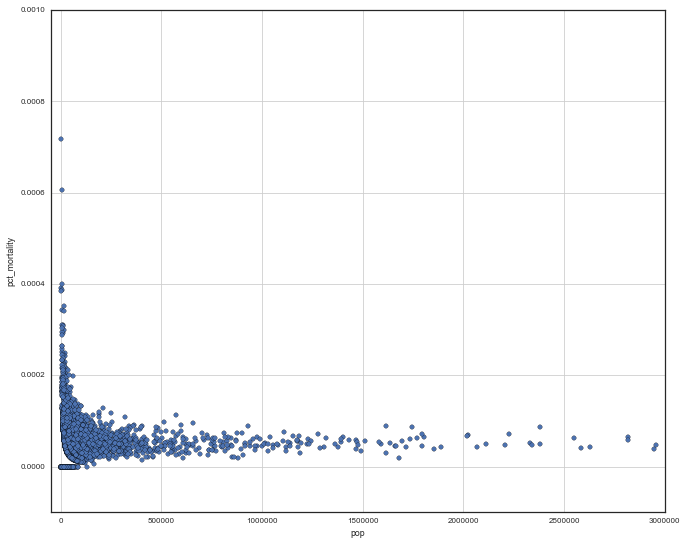

In [51]:
kCancer = pd.DataFrame.from_csv("HW6.csv")
kCancer.head()

kCancer.plot(kind='scatter',x="pop",y="pct_mortality",ylim=(-.0001,0.001),xlim=(-50000,3000000),figsize=(11,9))

In [113]:
from scipy.stats import gamma, nbinom, uniform, norm

from scipy.special import gammaln
virginia=kCancer[kCancer.state=="MICHIGAN"]
#virginia = kCancer

print virginia['pop'].mean()
#virginia=kCancer
# cancer=kCancer['dc'].values
# population=kCancer['pop'].values
# numlambdas=cancer.shape[0]
cancer=virginia['dc'].values
population=virginia['pop'].values
numlambdas=cancer.shape[0]
print numlambdas

#lambdas here are 5 year rates, ie so they compare directly to our 5 year column
aa=.002
ab=0.0001
ba=.01
bb=.01

log_prior_a = lambda a: gamma.pdf(a, aa,scale=1./ab)
log_prior_b = lambda b: gamma.pdf(b, ba,scale=1./bb)

draw_lambdas2 = lambda a,b: gamma.rvs(a+cancer,scale=1./(b+population), size=numlambdas)

draw_beta2 = lambda a,b, lambdas: gamma.rvs(numlambdas*a+ba, scale=1./(np.sum(lambdas)+bb))

def log_cond_alpha2(a,b, lambdas):
    return numlambdas*(a*np.log(b) - gammaln(a)) + a*np.sum(np.log(lambdas)) + (aa-1)*np.log(a) - ba*a


def draw_alpha2(a,b,thetas, proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)
    num = log_cond_alpha2(astar,b, thetas)
    den = log_cond_alpha2(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (astar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a


228975.13253
83


0.002 0.0001
(array(20.0), array(200000.0))


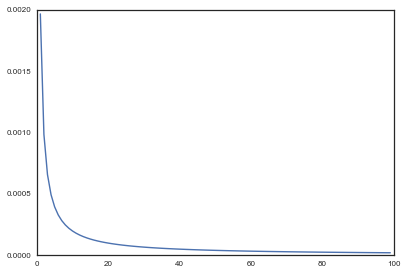

In [114]:
print aa, ab
x=np.arange(0,100,1)
print gamma.stats(aa, scale=1./ab, moments='mv')
plt.plot(x, gamma.pdf(x, aa,scale=1./ab))

0.01 0.01
(array(1.0), array(100.0))


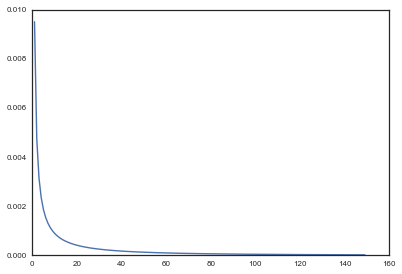

In [115]:
print ba, bb
x=np.arange(0,150,1)
print gamma.stats(ba, scale=1./bb, moments='mv')
plt.plot(x,gamma.pdf(x, ba,scale=1./bb))

In [116]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
lambdas=np.empty((totaltraces, numlambdas))

alpha_prop_sd=.25
alphas[0]=20.
betas[0]=10000.
#regularize init by adding one poor soul
lambdas[0,:] = (cancer+1)/(population)
#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

This is the main loop of our sampler. Notice the structure: for alpha we take from the previous step, for beta we take the changed alpha from the current step, and for the thetas we take both alpha and beta from the current step.

In [117]:
for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha2(alphas[m-1],betas[m-1],lambdas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta2(alphas[m],betas[m-1],lambdas[m-1,:])
    lambdas[m,:] = draw_lambdas2(alphas[m],betas[m])


In [118]:
accepteds['alpha'], accepteds['beta'], totaltraces

(48392, 0, 220000)

In [119]:
alphatrace=alphas[burnin+1:totaltraces:20]
betatrace=betas[burnin+1:totaltraces:20]
lambdastrace=lambdas[burnin+1:totaltraces:20,:]
print lambdastrace.shape, alphatrace.shape

(10000, 83) (10000,)


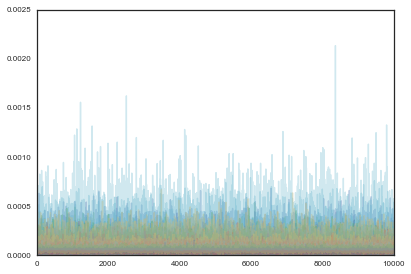

In [120]:
plt.plot(lambdastrace, alpha=0.3);

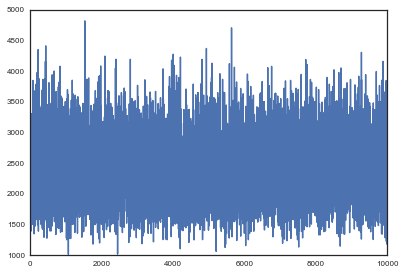

In [121]:
plt.plot(betatrace)

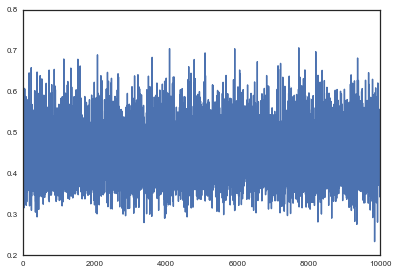

In [122]:
plt.plot(alphatrace);

It looks like we have good convergence for our alphas, betas, and lambdas(thetas) because the traceplots aren't showing a lot of autocorrelation.  Let's check directly.

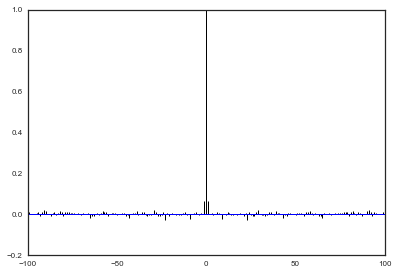

In [123]:
plt.acorr(alphatrace-np.mean(alphatrace), normed=True, maxlags=100, lw=1 );

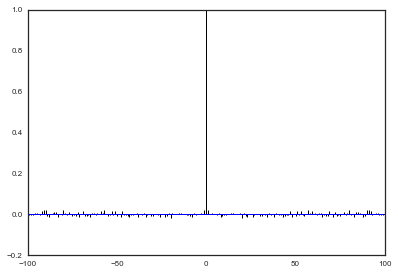

In [124]:
plt.acorr(betatrace-np.mean(betatrace), normed=True, maxlags=100, lw=1 );

So it looks like we have kept autocorrelation to a minimum.  Now let's look at some posterior plots:

### Plots of the posterior

We plot the $\alpha$ and $\beta$ marginals.  We also see the marginal of $\theta_1$.

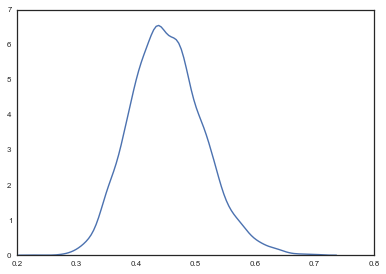

In [125]:
sns.kdeplot(alphatrace)

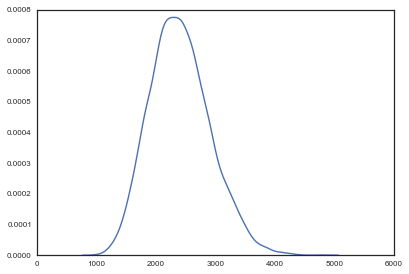

In [126]:
sns.kdeplot(betatrace)

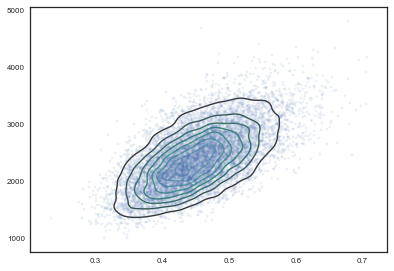

In [127]:
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)

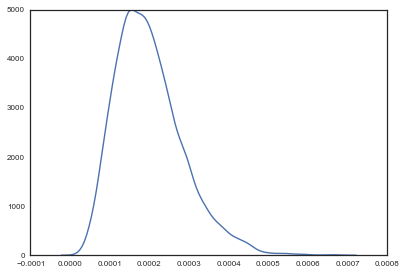

In [128]:
sns.kdeplot(lambdastrace[:,0])

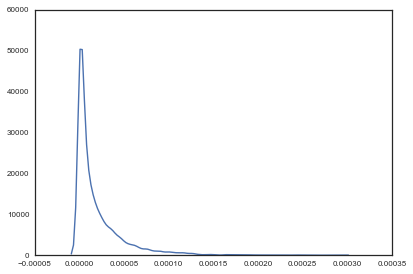

In [129]:
sns.kdeplot(lambdastrace[:,1])

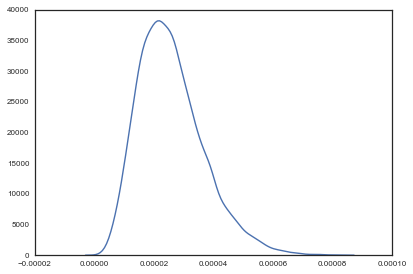

In [130]:
sns.kdeplot(lambdastrace[:,2])

In [131]:
print np.median(alphatrace), np.median(betatrace)

0.449447645329 2377.05174186


### Understanding the posterior

We plot the observed cancer death rates on the x-axis against posterior medians for each of the  θ's on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. We'd expect that the bayesian method regularizes the data, creating "regression to the mean", allowing an appropriate framework to deal with  low sample sizes and outliers, etc in observed data. Furthermore, posterior confidence intervals are wide because having a full posterior distribution on the hyperparameters spread things out (the intervals are wider for lower sample sizes).


In [132]:
percentiles=np.percentile(lambdastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles
elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

In [133]:
ratios=virginia['dc'].astype(float)/virginia['pop']

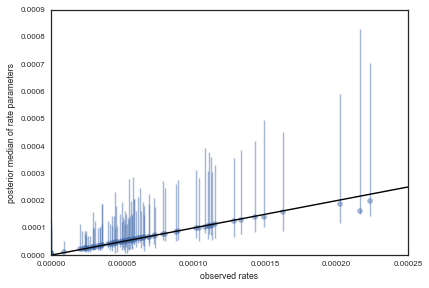

In [134]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.00025],[0,0.00025],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

Now this is the (expected) posterior plot for hyperparameters that interact well with our data and conditionals. So without using our expert "priors" we're essentially replicating the predited outcomes given the data. What if we use the expert values?

In [193]:
from scipy.special import gammaln
virginia=kCancer[kCancer.state=="MICHIGAN"]
#virginia = kCancer

print virginia['pop'].mean()
#virginia=kCancer
# cancer=kCancer['dc'].values
# population=kCancer['pop'].values
# numlambdas=cancer.shape[0]
cancer=virginia['dc'].values
population=virginia['pop'].values
numlambdas=cancer.shape[0]

#lambdas here are 5 year rates, ie so they compare directly to our 5 year column
aa=.002
ab=0.0001
ba= 20
bb=.0002

log_prior_a = lambda a: gamma.pdf(a, aa,scale=1./ab)
log_prior_b = lambda b: gamma.pdf(b, ba,scale=1./bb)

draw_lambdas =  lambda a,b: gamma.rvs(a+cancer,scale=1./(b+population), size=numlambdas)
draw_lambdas2 = lambda a,b: gamma.rvs(a+cancer,scale=1./(b+population), size=numlambdas)

draw_beta2 = lambda a,b, lambdas: gamma.rvs(numlambdas*a+ba, scale=1./(np.sum(lambdas)+bb))

def log_cond_alpha(a,b, lambdas):
    return numlambdas*(a*np.log(b) - gammaln(a)) + a*np.sum(np.log(lambdas)) + log_prior_a(a)

def log_cond_alpha2(a,b, lambdas):
    return numlambdas*(a*np.log(b) - gammaln(a)) + a*np.sum(np.log(lambdas)) + (aa-1)*np.log(a) - ba*a


def log_cond_beta(a,b, lambdas):
    return np.log(gamma.pdf(b, numlambdas*a+1,scale=1./(np.sum(lambdas)))) + log_prior_b(b)

def draw_alpha2(a,b,thetas, proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)
    num = log_cond_alpha2(astar,b, thetas)
    den = log_cond_alpha2(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (astar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)
    num = log_cond_alpha(astar,b, thetas)
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (astar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (bstar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

228975.13253


We've changed ba and bb.  What does our new beta prior look like?

20 0.0002
(array(100000.0), array(500000000.0))


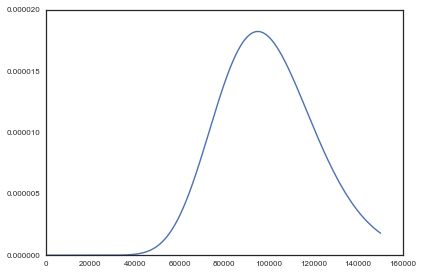

In [194]:
print ba, bb
x=np.arange(0,150000,1)
print gamma.stats(ba, scale=1./bb, moments='mv')
plt.plot(x,gamma.pdf(x, ba,scale=1./bb))

In [195]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
lambdas=np.empty((totaltraces, numlambdas))

alpha_prop_sd=1
#beta_prop_sd=50.
alphas[0]=20.
betas[0]=10000.
#regularize init by adding one poor soul
lambdas[0,:] = (cancer+1)/(population)
#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

In [196]:
for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha2(alphas[m-1],betas[m-1],lambdas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta2(alphas[m],betas[m-1],lambdas[m-1,:])
    lambdas[m,:] = draw_lambdas2(alphas[m],betas[m])

In [197]:
accepteds['alpha'], accepteds['beta'], totaltraces

(33256, 0, 220000)

In [198]:
alphatrace=alphas[burnin+1:totaltraces:20]
betatrace=betas[burnin+1:totaltraces:20]
lambdastrace=lambdas[burnin+1:totaltraces:20,:]
print lambdastrace.shape, alphatrace.shape

(10000, 83) (10000,)


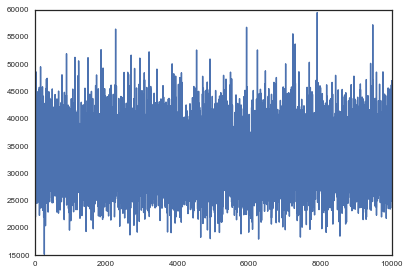

In [199]:
plt.plot(betatrace)

So we're seeing not so much autocorrelation in the traces which is a good sign!

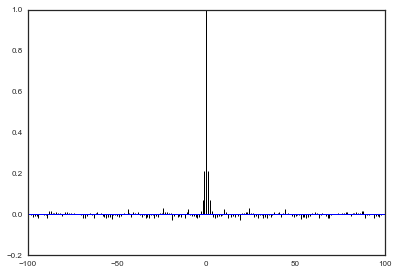

In [200]:
plt.acorr(betatrace-np.mean(betatrace), normed=True, maxlags=100, lw=1 );

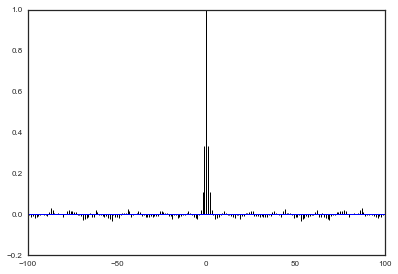

In [201]:
plt.acorr(alphatrace-np.mean(alphatrace), normed=True, maxlags=100, lw=1 );

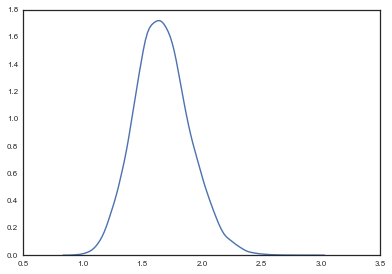

In [202]:
sns.kdeplot(alphatrace)

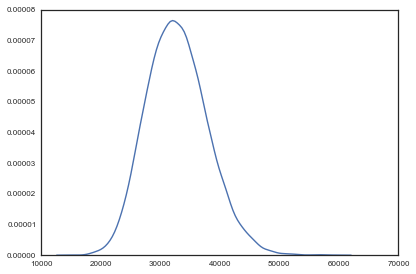

In [203]:
sns.kdeplot(betatrace)

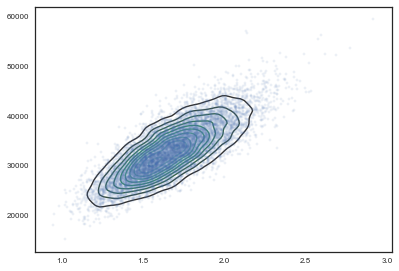

In [204]:
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)

In [205]:
percentiles=np.percentile(lambdastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles
elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

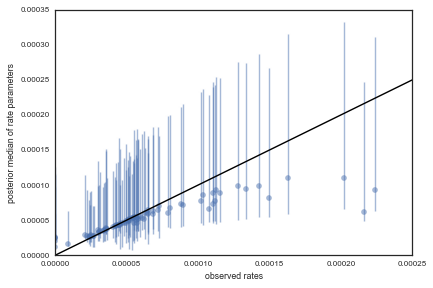

In [206]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.00025],[0,0.00025],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

Using the "expert" values we see the regularization effect that we postulated earlier.  We see a cluster of values near the expected cancer death rate 0.00005, and at those observed rates, the posterior medians match the observations.  At lower rates or higherhowever where the observations underestimate or over estimate the data, our hierachical model with the expert priors serves as the regularizer with the posterior median rates pulling towards the expected rate ot .00005.